In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Sep 18 23:41:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import sys
path_workspace = '/content/r2_learning_calibration'
# path_source = '/content/drive/MyDrive/RAVEN Calibration/experiments/recorded_trajs'
# sys.path.append(path_source)

In [3]:
!mkdir '/content/r2_learning_calibration'
!mkdir '/content/r2_learning_calibration/data'

# !unzip -q "/content/drive/MyDrive/RAVEN Calibration/experiments/recorded_trajs/record_exp3_time_decay.zip" -d '/content/r2_learning_calibration/data'

# !unzip -q "/content/drive/MyDrive/RAVEN Calibration/experiments/recorded_trajs/record_exp3s_time_decay_500g.zip" -d '/content/r2_learning_calibration/data'

!unzip -q "/content/drive/MyDrive/RAVEN Calibration/experiments/recorded_trajs/record_exp4s_home_decay.zip" -d '/content/r2_learning_calibration/data'

# !unzip -q "/content/drive/MyDrive/RAVEN Calibration/experiments/recorded_trajs/record_exp4_home_in_train_test.zip" -d '/content/r2_learning_calibration/data'



In [4]:
import os
import time
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import heapq

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers

from sklearn.preprocessing import StandardScaler

from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

In [5]:
# parameter list
# file_train_list_ = ['data_record_yz_05_1.csv', 'data_record_yz_03_1.csv', 'data_record_yz_025_1.csv', 'data_record_yz_02_1.csv', 'data_record_yz_016_1.csv'] # for 0g
file_train_list_ = ['data_record_yz_05.csv', 'data_record_yz_03.csv', 'data_record_yz_025.csv', 'data_record_yz_02.csv', 'data_record_yz_016.csv'] # for 500g and homing decay
# file_train_list_ = ['data_record_yz_05_hm0.csv', 'data_record_yz_03_hm1.csv', 'data_record_yz_025_hm1.csv', 'data_record_yz_02_hm1.csv', 'data_record_yz_016_hm0.csv'] # for homing in train



# file_test_list_ = ['data_record_rand1200_h0.csv', 'data_record_rand1200_h1.csv', 'data_record_rand1200_h2.csv', 'data_record_rand1200_h3.csv', 'data_record_rand1200_h4.csv', 'data_record_rand1200_h5.csv']
file_test_list_ = ['data_record_rand1200_hm0.csv', 'data_record_rand1200_hm1.csv', 'data_record_rand1200_hm2.csv', 'data_record_rand1200_hm3.csv', 'data_record_rand1200_hm4.csv', 'data_record_rand1200_hm5.csv']


sampling_rate = 5
time_window = 40
lstm_unit = 300
hidden_layers_ = [[300]]
learning_rate = 0.0005
batch_size = 1024
epochs = 600

kernel_regu_l1 = 1e-4  #defult 1e-5, cur best 5e-5
kernel_regu_l2 = 1e-3  #defult 1e-4, cur best 5e-4
bias_regu = 0      #defult 1e-4, cur best 5e-4
activity_regu = 0   #defult 1e-5, cur best 5e-5



# feature_list = [np.arange(12,82),np.arange(114,130),np.arange(194,212)]
# feature_list = [np.arange(12,82),np.arange(98,130), np.arange(146,212), np.arange(228,252)] # this feature set excluded encoder values, motor pose, encoder offsets
# feature_list = [np.arange(12,82),np.arange(98,133), np.arange(146,212), np.arange(228,252)] # included mpos for joint 123, works
# feature_list = [np.arange(12,82),np.arange(98,133), np.arange(134,212), np.arange(228,252)] ##### only excluded 'joint 4' the void joint, works
# feature_list = [np.arange(29,82),np.arange(98,130), np.arange(146,178), np.arange(210,212), np.arange(228,252)] # No jpos, jpos_d, mpo, mpos_d
# feature_list = [np.arange(12,13), # time stamp
#                 np.arange(13,29), # jpos
#                 np.arange(29,30), # run level
#                 np.arange(30,31), # sub level
#                 np.arange(31,32), # last_seq
#                 np.arange(32,34), # type
#                 np.arange(34,40), # pos
#                 np.arange(40,58), # ori
#                 np.arange(58,76), # ord_d
#                 np.arange(76,82), # pos_d
#                 #np.arange(82,98), # enc_val
#                 np.arange(98,114), # dac_val
#                 np.arange(114,130), # tau
#                 np.arange(130,133),np.arange(133,146), # mpos
#                 np.arange(146,162), #  mvel
#                 np.arange(162,178), # jvel
#                 np.arange(178,194), # mpos_d
#                 np.arange(194,210), # jpos_d
#                 np.arange(210,212), # grasp_d
#                 #np.arange(212,228), # enc_offset
#                 np.arange(228,240), # jac_vel
#                 np.arange(240,252)] # jac_f

# left arm only ----------------------------
# feature_list = [np.arange(12,13), # time stamp
#                 np.arange(13,21), # jpos
#                 np.arange(29,30), # run level
#                 np.arange(30,31), # sub level
#                 np.arange(31,32), # last_seq
#                 np.arange(32,33), # type
#                 np.arange(34,37), # pos
#                 np.arange(40,49), # ori
#                 np.arange(58,67), # ord_d
#                 np.arange(76,79), # pos_d
#                 #np.arange(82,98), # enc_val
#                 np.arange(98,106), # dac_val
#                 np.arange(114,122), # tau
#                 np.arange(130,133),np.arange(133,138), # mpos
#                 np.arange(146,154), #  mvel
#                 np.arange(162,170), # jvel
#                 np.arange(178,186), # mpos_d
#                 np.arange(194,202), # jpos_d
#                 np.arange(210,211), # grasp_d
#                 #np.arange(212,228), # enc_offset
#                 np.arange(228,234), # jac_vel
#                 np.arange(240,246)] # jac_f

feature_list = [np.arange(12,13), # time stamp
                np.arange(13,29), # jpos
                np.arange(29,30), # run level
                np.arange(30,31), # sub level
                np.arange(31,32), # last_seq
                np.arange(32,34), # type
                np.arange(34,40), # pos
                np.arange(40,58), # ori
                np.arange(58,76), # ord_d
                np.arange(76,82), # pos_d
                #np.arange(82,98), # enc_val
                np.arange(98,114), # dac_val
                np.arange(114,130), # tau
                np.arange(130,133),np.arange(134,146), # mpos
                np.arange(146,162), #  mvel
                np.arange(162,178), # jvel
                np.arange(178,194), # mpos_d
                np.arange(194,210), # jpos_d
                np.arange(210,212), # grasp_d
                #np.arange(212,228), # enc_offset
                np.arange(228,240), # jac_vel
                np.arange(240,252)] # jac_f

# left arm only ----------------------------
# feature_list = [
#                 np.arange(13,21), # jpos
#                 np.arange(32,33), # type
#                 np.arange(114,122), # tau
#                 np.arange(130,133),np.arange(133,138), # mpos
#                 np.arange(146,154), #  mvel
#                 np.arange(162,170), # jvel
#                 np.arange(178,186), # mpos_d
#                 np.arange(194,202), # jpos_d
#                 np.arange(210,211), # grasp_d
#                 #np.arange(212,228), # enc_offset
#                 np.arange(228,234), # jac_vel
#                 np.arange(240,246)] # jac_f


noise_type = 'no_noise'
noise_list = [np.arange(82,98), # enc_val
              np.arange(212,228) # enc_offset
              ]

# noise_type = 'add_sub_noise'
# noise_list = [np.arange(82,98) # enc_val
#               ]

# joint_offset = 2
# noise_type = 'stdv'
# noise_list = [np.arange(13+joint_offset,14+joint_offset), # jpos
#               np.arange(98+joint_offset,99+joint_offset), # dac_val
#               np.arange(114+joint_offset,115+joint_offset), # tau
#               np.arange(130+joint_offset,131+joint_offset),
#               np.arange(146+joint_offset,147+joint_offset), #  mvel
#               np.arange(162+joint_offset,163+joint_offset), # jvel
#               np.arange(178+joint_offset,179+joint_offset), # mpos_d
#               np.arange(194+joint_offset,195+joint_offset) # jpos_d
#               ]

feature_select = np.array([])
for feature in feature_list:
  feature_select = np.hstack([feature_select, feature])
feature_select = feature_select.astype(int)
feature_dim = feature_select.size

noise_select = np.array([])
for noise in noise_list:
  noise_select = np.hstack([noise_select, noise])
noise_select = noise_select.astype(int)



Training data loaded, shape:
(70178, 252)
Test data loaded, shape:
(30488, 252)
(30583, 252)
(30471, 252)
(30629, 252)
(31105, 252)
(30634, 252)


Text(0.5, 1.0, 'Joint 3 linear correct')

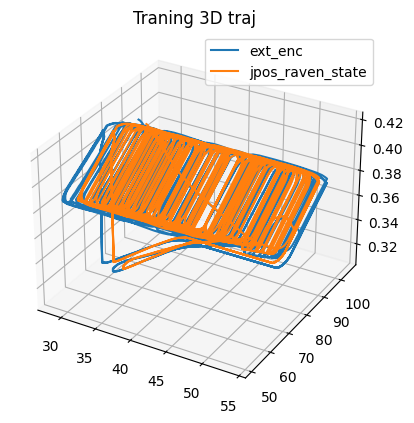

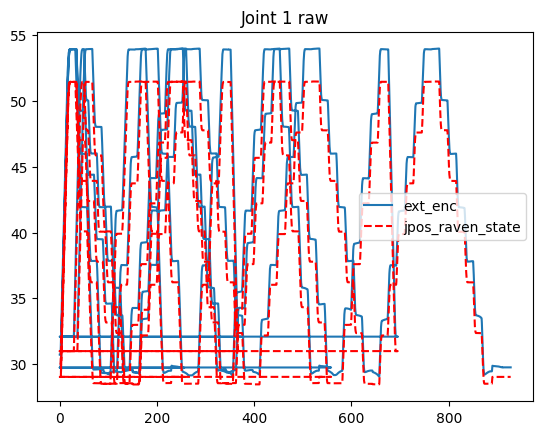

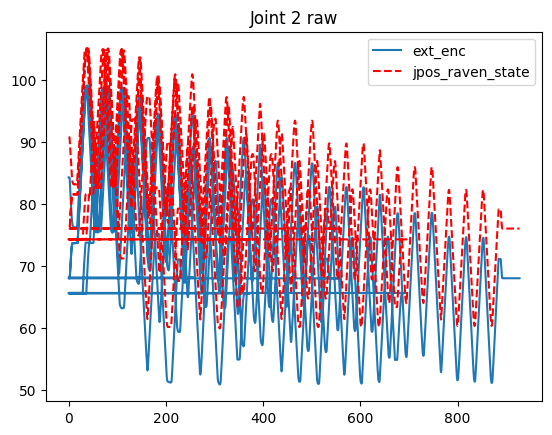

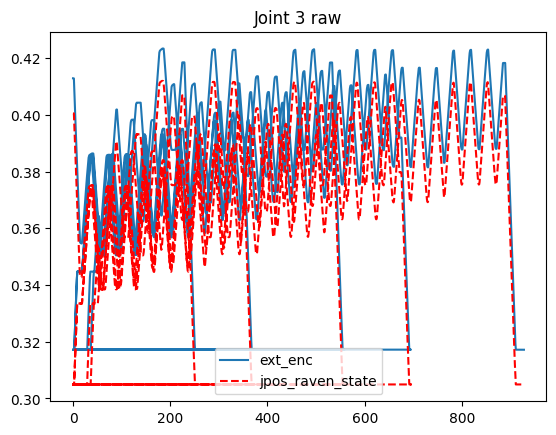

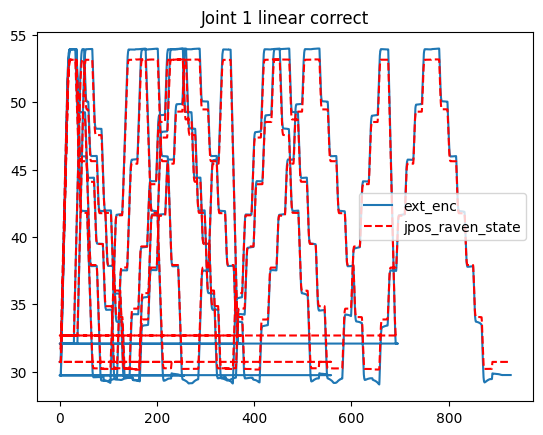

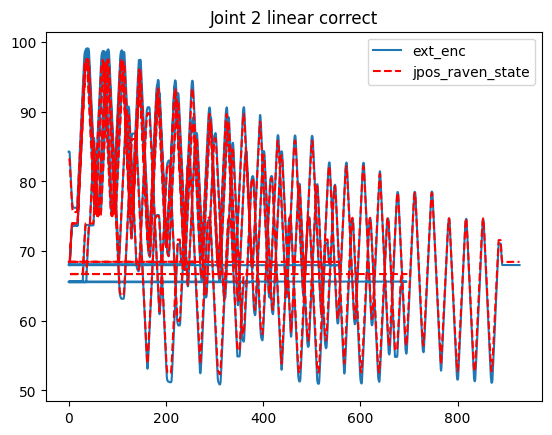

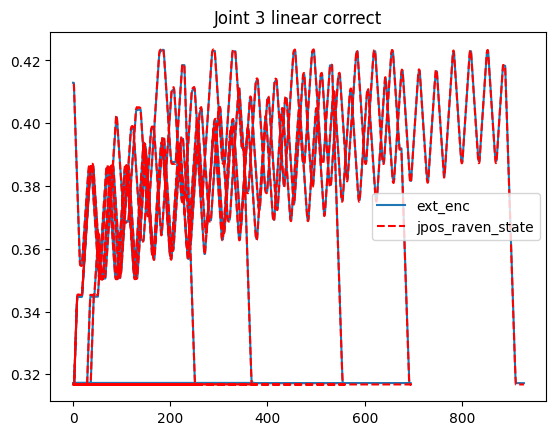

In [6]:
# import data
path_data = '/content/r2_learning_calibration/data/'


# Load training data
first_call = True
for file_training in file_train_list_:
  data = np.loadtxt(path_data + file_training, delimiter = ',')
  # jpos = data[:, 13:29]
  # jpos_d = data[:, 194:210]
  # data[:, 13:29] = jpos_d
  # data[:, 194:210] = jpos
  # data[:, 194:210] = data[:, 13:29] # [temp] for tesing jpos and jpos_d
  if first_call:
    data_train = data
    first_call = False
  else:
    data_train = np.vstack((data_train, data))

# Load testing data
data_test_list = []
for file_test in file_test_list_:
  data = np.loadtxt(path_data + file_test, delimiter = ',')
  # jpos = data[:, 13:29]
  # jpos_d = data[:, 194:210]
  # data[:, 13:29] = jpos_d
  # data[:, 194:210] = jpos
  # data[:, 194:210] = data[:, 13:29] # [temp] for tesing jpos and jpos_d
  data_test_list.append(data)


# load less validation data for faster training
data_vali = np.loadtxt(path_data + file_test_list_[0], delimiter = ',')
data_vali = data_vali[:10000,:]

# # loading validation data
# first_call = True
# for file_test in file_test_list_:
#   data = np.loadtxt(path_data + file_training, delimiter = ',')
#   if first_call:
#     data_vali = data
#     first_call = False
#   else:
#     data_vali = np.vstack((data_vali, data))



print('Training data loaded, shape:')
print(data_train.shape)
print('Test data loaded, shape:')
for data_test in data_test_list:
  print(data_test.shape)

rad2deg = 180.0/np.pi
deg2rad = np.pi/180.0

# load the data for visualization only, joint 1 and 2 will be in deg, joint 3 in m
time_line = data_train[:,0]
ext_jpos_1 = data_train[:,1] *rad2deg   # joint pose from external joint encoders
ext_jpos_2 = data_train[:,2] *rad2deg
ext_jpos_3 = data_train[:,3]
rs_jpos_1 = data_train[:,13]            # joint pose from ravenstate
rs_jpos_2 = data_train[:,14]
rs_jpos_3 = data_train[:,15] *deg2rad

rs_jpos_1_lc = rs_jpos_1 + (np.mean(ext_jpos_1)-np.mean(rs_jpos_1))
rs_jpos_2_lc = rs_jpos_2 + (np.mean(ext_jpos_2)-np.mean(rs_jpos_2))
rs_jpos_3_lc = rs_jpos_3 + (np.mean(ext_jpos_3)-np.mean(rs_jpos_3))

bias_jpos_1 = np.mean(ext_jpos_1)-np.mean(rs_jpos_1)
bias_jpos_2 = np.mean(ext_jpos_2)-np.mean(rs_jpos_2)
bias_jpos_3 = np.mean(ext_jpos_3)-np.mean(rs_jpos_3)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(ext_jpos_1, ext_jpos_2, ext_jpos_3)
ax.plot3D(rs_jpos_1, rs_jpos_2, rs_jpos_3)
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Traning 3D traj')

fig = plt.figure()
plt.plot(time_line, ext_jpos_1)
plt.plot(time_line, rs_jpos_1, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 1 raw')

fig = plt.figure()
plt.plot(time_line, ext_jpos_2)
plt.plot(time_line, rs_jpos_2, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 2 raw')

fig = plt.figure()
plt.plot(time_line, ext_jpos_3)
plt.plot(time_line, rs_jpos_3, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 3 raw')

fig = plt.figure()
plt.plot(time_line, ext_jpos_1)
plt.plot(time_line, rs_jpos_1_lc, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 1 linear correct')

fig = plt.figure()
plt.plot(time_line, ext_jpos_2)
plt.plot(time_line, rs_jpos_2_lc, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 2 linear correct')

fig = plt.figure()
plt.plot(time_line, ext_jpos_3)
plt.plot(time_line, rs_jpos_3_lc, 'r--')
plt.legend(('ext_enc','jpos_raven_state'))
plt.title('Joint 3 linear correct')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 300)               458100    
                                                                 
 dense (Dense)               (None, 300)               90300     
                                                                 
 dense_1 (Dense)             (None, 3)                 903       
                                                                 
Total params: 549303 (2.10 MB)
Trainable params: 549303 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
69/69 [==============================] - 1s 11ms/step - loss: 0.0341 - mean_absolute_error: 0.0853 - mean_absolute_percentage_error: 81.0185
{'loss': 0.034064020961523056, 'mean_absolute_error': 0.0852762907743454, 'mean_absolute_percentage_error': 81.01850128173828}
Training time:
7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


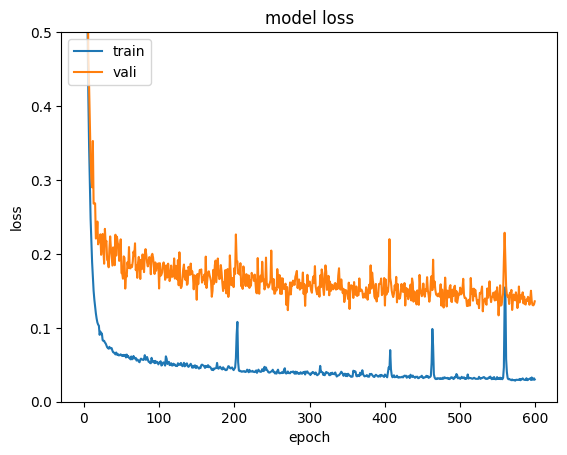

30/30 [==============================] - 1s 9ms/step
(30448, 3)
30/30 [==============================] - 0s 9ms/step
(30543, 3)
30/30 [==============================] - 0s 10ms/step
(30431, 3)
30/30 [==============================] - 0s 13ms/step
(30589, 3)
31/31 [==============================] - 1s 15ms/step
(31065, 3)
30/30 [==============================] - 1s 16ms/step
(30594, 3)
-------------------
Learning Calibration RMSE Joint 1 (deg):
[0.1834297583649127, 0.23684433718011144, 0.20677005636652201, 0.18943808271004994, 0.23215926002294077, 0.1816615400892595]
ravenstate RMSE Joint 1 linear corrected (deg):
[0.8410142150898341, 0.9225172943817711, 0.8650912226983484, 0.8458290816703965, 0.8689325664021942, 0.818291048859771]
ravenstate RMSE Joint 1 (deg):
[1.904085474590229, 1.8572591913160315, 1.8526989508681124, 1.8667692035312935, 1.8329830004666239, 1.878774866172014]
-------------------
Learning Calibration RMSE Joint 2 (deg):
[0.2646980328152388, 0.3575961036565194, 0.2776

In [ ]:
repeat_times = 5


# Training
x_train = data_train[:, feature_select]
x_train[:,0] = data_train[:, 0] # change the time stamp to relative time (start with 0)
y_train = data_train[:, 1:4]

ext_jpos_1 = data_train[:,1] *rad2deg   # joint pose from external joint encoders
ext_jpos_2 = data_train[:,2] *rad2deg
ext_jpos_3 = data_train[:,3]
rs_jpos_1 = data_train[:,13]            # joint pose from ravenstate
rs_jpos_2 = data_train[:,14]
rs_jpos_3 = data_train[:,15] *deg2rad

rs_jpos_1_lc = rs_jpos_1 + (np.mean(ext_jpos_1)-np.mean(rs_jpos_1))
rs_jpos_2_lc = rs_jpos_2 + (np.mean(ext_jpos_2)-np.mean(rs_jpos_2))
rs_jpos_3_lc = rs_jpos_3 + (np.mean(ext_jpos_3)-np.mean(rs_jpos_3))

bias_jpos_1 = np.mean(ext_jpos_1)-np.mean(rs_jpos_1)
bias_jpos_2 = np.mean(ext_jpos_2)-np.mean(rs_jpos_2)
bias_jpos_3 = np.mean(ext_jpos_3)-np.mean(rs_jpos_3)

y_train[:,0] = ext_jpos_1 - rs_jpos_1
y_train[:,1] = ext_jpos_2 - rs_jpos_2
y_train[:,2] = ext_jpos_3 - rs_jpos_3

# scale the training set
scaler_x_train = StandardScaler()
scaler_y_train = StandardScaler()
x_train_scaled = scaler_x_train.fit_transform(x_train)
y_train_scaled = scaler_y_train.fit_transform(y_train)

# Validation
x_vali = data_vali[:, feature_select]
x_vali[:,0] = data_vali[:, 0] # change the time stamp to relative time (start with 0)
y_vali = data_vali[:, 1:4]
y_vali[:,0] = data_vali[:,1] *rad2deg - data_vali[:,13]
y_vali[:,1] = data_vali[:,2] *rad2deg - data_vali[:,14]
y_vali[:,2] = data_vali[:,3] - data_vali[:,15] *deg2rad
x_vali_scaled = scaler_x_train.transform(x_vali)
y_vali_scaled = scaler_y_train.transform(y_vali)

# data generator for lstm
data_lstm_train = TimeseriesGenerator(x_train_scaled, y_train_scaled,
                               length=time_window, sampling_rate=sampling_rate,
                               batch_size=batch_size)

data_lstm_vali = TimeseriesGenerator(x_vali_scaled, y_vali_scaled,
                               length=time_window, sampling_rate=sampling_rate,
                               batch_size=batch_size)


x_test_list = []
y_test_list = []
time_line_list = []
ext_jpos_1_list = []
ext_jpos_2_list = []
ext_jpos_3_list = []
rs_jpos_1_list = []
rs_jpos_2_list = []
rs_jpos_3_list = []
rs_jpos_1_lc_list = []
rs_jpos_2_lc_list = []
rs_jpos_3_lc_list = []
for data_test in data_test_list:
  time_line = data_test[:,0]
  ext_jpos_1 = data_test[:,1] *rad2deg   # joint pose from external joint encoders
  ext_jpos_2 = data_test[:,2] *rad2deg
  ext_jpos_3 = data_test[:,3]

  rs_jpos_1 = data_test[:,13]            # joint pose from ravenstate
  rs_jpos_2 = data_test[:,14]
  rs_jpos_3 = data_test[:,15] *deg2rad

  rs_jpos_1_lc = rs_jpos_1 + bias_jpos_1
  rs_jpos_2_lc = rs_jpos_2 + bias_jpos_2
  rs_jpos_3_lc = rs_jpos_3 + bias_jpos_3


  # add noise for ablation
  for noise_idx in noise_select:
    if noise_type == 'stdv':
      data_test[:, noise_idx] = data_test[:, noise_idx] + np.random.default_rng().uniform(low=-np.std(data_test[:, noise_idx]), high=np.std(data_test[:, noise_idx]), size=data_test[:, noise_idx].shape)
    if noise_type == 'mean':
      data_test[:, noise_idx] = data_test[:, noise_idx] + np.random.default_rng().uniform(low=-0.5*np.mean(np.abs(data_test[:, noise_idx])), high=0.5*np.mean(np.abs(data_test[:, noise_idx])), size=data_test[:, noise_idx].shape)
    if noise_type == 'zero':
      data_test[:, noise_idx] = data_test[:, noise_idx] * 0
    if noise_type == 'min-max':
      range_idx = np.mean(heapq.nlargest(100 ,data_test[:, noise_idx])) - np.mean(heapq.nsmallest(100 ,data_test[:, noise_idx]))
      data_test[:, noise_idx] = data_test[:, noise_idx] + np.random.default_rng().uniform(low=-0.5 * range_idx, high=0.5 * range_idx, size=data_test[:, noise_idx].shape)
    if noise_type == 'temp':
      data_test[:, noise_idx] = data_test[:, noise_idx] * -1.0
    if noise_type == 'no_noise':
      _ = 1
    if noise_type == 'add_sub_noise':
      noise_added = np.random.default_rng().uniform(low=-np.std(data_test[:, noise_idx]), high=np.std(data_test[:, noise_idx]), size=data_test[:, noise_idx].shape)
      data_test[:, noise_idx] + noise_added
      data_test[:, noise_idx+114] - noise_added

  x_test = data_test[:, feature_select]
  x_test[:,0] = data_test[:, 0] # change the time stamp to relative time (start with 0)
  y_test = data_test[:, 1:4]


  x_test_list.append(x_test)
  y_test_list.append(y_test)
  time_line_list.append(time_line)
  ext_jpos_1_list.append(ext_jpos_1)
  ext_jpos_2_list.append(ext_jpos_2)
  ext_jpos_3_list.append(ext_jpos_3)
  rs_jpos_1_list.append(rs_jpos_1)
  rs_jpos_2_list.append(rs_jpos_2)
  rs_jpos_3_list.append(rs_jpos_3)
  rs_jpos_1_lc_list.append(rs_jpos_1_lc)
  rs_jpos_2_lc_list.append(rs_jpos_2_lc)
  rs_jpos_3_lc_list.append(rs_jpos_3_lc)


list_finish_time = []
list_rmse_j1_pdt = []
list_rmse_j1_rs_lc = []
list_rmse_j1_rs = []
list_rmse_j2_pdt = []
list_rmse_j2_rs_lc = []
list_rmse_j2_rs = []
list_rmse_j3_pdt = []
list_rmse_j3_rs_lc = []
list_rmse_j3_rs = []

list_mxabse_j1_pdt = []
list_mxabse_j1_rs_lc = []
list_mxabse_j1_rs = []
list_mxabse_j2_pdt = []
list_mxabse_j2_rs_lc = []
list_mxabse_j2_rs = []
list_mxabse_j3_pdt = []
list_mxabse_j3_rs_lc = []
list_mxabse_j3_rs = []

for i in range(0, repeat_times):
  np.random.seed(10*i + 3)
  tf.random.set_seed(10*i + 3)
  tf.keras.utils.set_random_seed(10*i + 3)

  dnn_model = None #clean the model
########################################################################################################
  class dnn_model():

      folder_workspace = None
      folder_NN = None

      model = None


      def set_workspace(self, folder):
          self.folder_workspace = folder
          self.folder_NN = self.folder_workspace + '/' + 'neural_network'
          try:
              os.mkdir(self.folder_workspace)
          except:
              _= 1
          try:
              os.mkdir(self.folder_NN)
          except:
              _= 1
          return None

      def build_model(self, time_window, lstm_unit, dim_input, dim_output, hidden_layers_ = [[200],[150],[100]], learning_rate = 0.001):
          self.model = Sequential()

          # input layer with lstm
          self.model.add(tf.keras.layers.GRU(lstm_unit,
                                             input_shape=(time_window, dim_input),
                                             kernel_regularizer=regularizers.L1L2(l1=kernel_regu_l1, l2=kernel_regu_l2),
                                             recurrent_regularizer=regularizers.L1L2(l1=kernel_regu_l1, l2=kernel_regu_l2)))

          # hidden layer
          for hidden_layer in hidden_layers_:
              self.model.add(Dense(units = hidden_layer[0],
                              activation='sigmoid',
                              use_bias=True,
                              kernel_initializer="glorot_uniform",
                              bias_initializer="zeros",
                              kernel_regularizer=regularizers.L1L2(l1=kernel_regu_l1, l2=kernel_regu_l2),
                              bias_regularizer=regularizers.L2(bias_regu),
                              activity_regularizer=regularizers.L2(activity_regu),
                              kernel_constraint=None,
                              bias_constraint=None,))

          # output layer
          self.model.add(Dense(units = dim_output,
                              activation='linear',
                              use_bias=True,
                              kernel_initializer="glorot_uniform",
                              bias_initializer="zeros",
                              kernel_regularizer=None,
                              bias_regularizer=None,
                              activity_regularizer=None,
                              kernel_constraint=None,
                              bias_constraint=None,))

          optimizer_method = tf.keras.optimizers.Adam(learning_rate=learning_rate,
                                  beta_1=0.9,
                                  beta_2=0.999,
                                  epsilon=1e-07,
                                  amsgrad=False,
                                  name="Adam")

          # loss_function = tf.keras.losses.LogCosh(reduction="auto", name="log_cosh")

          metrics_function = [tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error", dtype=None),
                              tf.keras.metrics.MeanAbsolutePercentageError(name="mean_absolute_percentage_error", dtype=None)]

          self.model.compile(optimizer = optimizer_method,
                            loss = 'mse',
                            metrics = metrics_function,
                            loss_weights=None,
                            weighted_metrics=None,
                            run_eagerly=None)

          return None

      def train_model(self, X, y, batch_size, epochs, validation_data=None, early_stop_min_delta = 0, early_stop_patience = 5):

          early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                          min_delta = early_stop_min_delta,
                                                          patience = early_stop_patience,
                                                          verbose=1,
                                                          mode="auto",
                                                          baseline=None,
                                                          restore_best_weights=True)

          History = self.model.fit(x = X,
                                  y = y,
                                  batch_size=batch_size,
                                  epochs = epochs,
                                  verbose=0,
                                  callbacks=[early_stop],
                                  validation_split=0.01,
                                  validation_data = validation_data,
                                  shuffle=True,
                                  class_weight=None,
                                  sample_weight=None,
                                  initial_epoch=0,
                                  steps_per_epoch=None,
                                  validation_steps=None,
                                  validation_batch_size=None,
                                  validation_freq=1,
                                  max_queue_size=10,
                                  workers=1,
                                  use_multiprocessing=False)

          return History

      def evaluate_model(self, X, y):
          test_result = self.model.evaluate(x = X,
                                              y = y,
                                              batch_size=None,
                                              verbose=1,
                                              sample_weight=None,
                                              steps=None,
                                              callbacks=None,
                                              max_queue_size=10,
                                              workers=1,
                                              use_multiprocessing=False,
                                              return_dict=True)

          return test_result

      def save_model(self, file_path = None):
          if file_path == None:
              file_path = self.folder_NN + '/' + 'model.h5'

          self.model.save(filepath = file_path,
                          overwrite=True,
                          include_optimizer=True,
                          save_format=None,
                          signatures=None,
                          options=None)
          return None

      def load_model(self, file_path = None):
          if file_path == None:
              file_path = self.folder_NN + '/' + 'model.h5'

          self.model = tf.keras.models.load_model(filepath = file_path)
          return None
########################################################################################################

  start_time = time.time()
  dnn_model = dnn_model()

  dnn_model.set_workspace('r2_learning_calibration/r2_cali_model')

  # dnn_model.build_model(dim_input = 17, dim_output = 3, hidden_layers_ = [[600],[500],[400]], learning_rate = 0.001)
  dnn_model.build_model(time_window = time_window, lstm_unit = lstm_unit, dim_input = feature_dim, dim_output = 3, hidden_layers_ = hidden_layers_, learning_rate = learning_rate)

  dnn_model.model.summary()

  train_history = dnn_model.train_model(X = data_lstm_train,
                                        y = None,
                                        batch_size = batch_size,
                                        epochs = epochs,
                                        validation_data = data_lstm_vali,
                                        early_stop_min_delta = 0,
                                        early_stop_patience = 1000)

  test_result = dnn_model.evaluate_model(X = data_lstm_train, y = None)
  print(test_result)

  dnn_model.save_model(file_path = None)

  finish_time = time.time() - start_time
  print('Training time:')
  print(str(time.time() - start_time))
  # summarize history for loss
  plt.figure()
  plt.ylim((0,0.5))
  plt.plot(train_history.history['loss'])
  plt.plot(train_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'vali'], loc='upper left')
  plt.show()

  rmse_j1_pdt_lst = []
  rmse_j2_pdt_lst = []
  rmse_j3_pdt_lst = []
  rmse_j1_rs_lst = []
  rmse_j2_rs_lst = []
  rmse_j3_rs_lst = []
  rmse_j1_rs_lc_lst = []
  rmse_j2_rs_lc_lst = []
  rmse_j3_rs_lc_lst = []

  mxabse_j1_pdt_lst = []
  mxabse_j2_pdt_lst = []
  mxabse_j3_pdt_lst = []
  mxabse_j1_rs_lst = []
  mxabse_j2_rs_lst = []
  mxabse_j3_rs_lst = []
  mxabse_j1_rs_lc_lst = []
  mxabse_j2_rs_lc_lst = []
  mxabse_j3_rs_lc_lst = []

  infer_time_lst = []

  idx = 0
  for x_test in x_test_list:
    y_test = y_test_list[idx]
    time_line = time_line_list[idx][time_window:]
    ext_jpos_1 = ext_jpos_1_list[idx][time_window:]
    ext_jpos_2 = ext_jpos_2_list[idx][time_window:]
    ext_jpos_3 = ext_jpos_3_list[idx][time_window:]
    rs_jpos_1 = rs_jpos_1_list[idx][time_window:]
    rs_jpos_2 = rs_jpos_2_list[idx][time_window:]
    rs_jpos_3 = rs_jpos_3_list[idx][time_window:]
    rs_jpos_1_lc = rs_jpos_1_lc_list[idx][time_window:]
    rs_jpos_2_lc = rs_jpos_2_lc_list[idx][time_window:]
    rs_jpos_3_lc = rs_jpos_3_lc_list[idx][time_window:]
    idx += 1
  # Evaluate and plot result -----------------------------------------------------
    x_test_scaled = scaler_x_train.transform(x_test)
    y_test_scaled = scaler_y_train.transform(y_test)
    data_lstm_test = TimeseriesGenerator(x_test_scaled, y_test_scaled,
                               length=time_window, sampling_rate=sampling_rate,
                               batch_size=batch_size)
    y_predict = dnn_model.model.predict(data_lstm_test)
    y_predict = scaler_y_train.inverse_transform(y_predict)
    print(y_predict.shape)

    pdt_jpos_1 = rs_jpos_1 + y_predict[:,0] #*rad2deg
    pdt_jpos_2 = rs_jpos_2 + y_predict[:,1] #*rad2deg
    pdt_jpos_3 = rs_jpos_3 + y_predict[:,2]

    rmse_j1_pdt = np.sqrt(np.mean(np.square(pdt_jpos_1 - ext_jpos_1)))
    rmse_j2_pdt = np.sqrt(np.mean(np.square(pdt_jpos_2 - ext_jpos_2)))
    rmse_j3_pdt = np.sqrt(np.mean(np.square(pdt_jpos_3 - ext_jpos_3)))
    rmse_j1_rs = np.sqrt(np.mean(np.square(rs_jpos_1 - ext_jpos_1)))
    rmse_j2_rs = np.sqrt(np.mean(np.square(rs_jpos_2 - ext_jpos_2)))
    rmse_j3_rs = np.sqrt(np.mean(np.square(rs_jpos_3 - ext_jpos_3)))
    rmse_j1_rs_lc = np.sqrt(np.mean(np.square(rs_jpos_1_lc - ext_jpos_1)))
    rmse_j2_rs_lc = np.sqrt(np.mean(np.square(rs_jpos_2_lc - ext_jpos_2)))
    rmse_j3_rs_lc = np.sqrt(np.mean(np.square(rs_jpos_3_lc - ext_jpos_3)))

    mxabse_j1_pdt = np.max(np.abs(pdt_jpos_1 - ext_jpos_1))
    mxabse_j2_pdt = np.max(np.abs(pdt_jpos_2 - ext_jpos_2))
    mxabse_j3_pdt = np.max(np.abs(pdt_jpos_3 - ext_jpos_3))
    mxabse_j1_rs = np.max(np.abs(rs_jpos_1 - ext_jpos_1))
    mxabse_j2_rs = np.max(np.abs(rs_jpos_2 - ext_jpos_2))
    mxabse_j3_rs = np.max(np.abs(rs_jpos_3 - ext_jpos_3))
    mxabse_j1_rs_lc = np.max(np.abs(rs_jpos_1_lc - ext_jpos_1))
    mxabse_j2_rs_lc = np.max(np.abs(rs_jpos_2_lc - ext_jpos_2))
    mxabse_j3_rs_lc = np.max(np.abs(rs_jpos_3_lc - ext_jpos_3))

    rmse_j1_pdt_lst.append(rmse_j1_pdt)
    rmse_j2_pdt_lst.append(rmse_j2_pdt)
    rmse_j3_pdt_lst.append(rmse_j3_pdt)
    rmse_j1_rs_lst.append(rmse_j1_rs)
    rmse_j2_rs_lst.append(rmse_j2_rs)
    rmse_j3_rs_lst.append(rmse_j3_rs)
    rmse_j1_rs_lc_lst.append(rmse_j1_rs_lc)
    rmse_j2_rs_lc_lst.append(rmse_j2_rs_lc)
    rmse_j3_rs_lc_lst.append(rmse_j3_rs_lc)

    mxabse_j1_pdt_lst.append(mxabse_j1_pdt)
    mxabse_j2_pdt_lst.append(mxabse_j2_pdt)
    mxabse_j3_pdt_lst.append(mxabse_j3_pdt)
    mxabse_j1_rs_lst.append(mxabse_j1_rs)
    mxabse_j2_rs_lst.append(mxabse_j2_rs)
    mxabse_j3_rs_lst.append(mxabse_j3_rs)
    mxabse_j1_rs_lc_lst.append(mxabse_j1_rs_lc)
    mxabse_j2_rs_lc_lst.append(mxabse_j2_rs_lc)
    mxabse_j3_rs_lc_lst.append(mxabse_j3_rs_lc)

  # testing inference time------------------------------------------------------------------
  # this generator is only for testing the inference time
  data_lstm_infer_test = TimeseriesGenerator(x_test_scaled, y_test_scaled,
                              length=time_window*5, sampling_rate=sampling_rate,
                              batch_size=1)
  infer_start_time = time.time()
  infer_No = 500
  # multi_infer = 25
  for i in range(infer_No):
    _ = dnn_model.model.predict(data_lstm_infer_test[i][0], verbose=0)
  infer_time_lst.append((time.time() - infer_start_time)/infer_No)
  #-----------------------------------------------------------------------------------------

  list_finish_time.append(finish_time)
  list_rmse_j1_pdt.append(rmse_j1_pdt_lst)
  list_rmse_j1_rs_lc.append(rmse_j1_rs_lc_lst)
  list_rmse_j1_rs.append(rmse_j1_rs_lst)
  list_rmse_j2_pdt.append(rmse_j2_pdt_lst)
  list_rmse_j2_rs_lc.append(rmse_j2_rs_lc_lst)
  list_rmse_j2_rs.append(rmse_j2_rs_lst)
  list_rmse_j3_pdt.append(rmse_j3_pdt_lst)
  list_rmse_j3_rs_lc.append(rmse_j3_rs_lc_lst)
  list_rmse_j3_rs.append(rmse_j3_rs_lst)

  list_mxabse_j1_pdt.append(mxabse_j1_pdt_lst)
  list_mxabse_j1_rs_lc.append(mxabse_j1_rs_lc_lst)
  list_mxabse_j1_rs.append(mxabse_j1_rs_lst)
  list_mxabse_j2_pdt.append(mxabse_j2_pdt_lst)
  list_mxabse_j2_rs_lc.append(mxabse_j2_rs_lc_lst)
  list_mxabse_j2_rs.append(mxabse_j2_rs_lst)
  list_mxabse_j3_pdt.append(mxabse_j3_pdt_lst)
  list_mxabse_j3_rs_lc.append(mxabse_j3_rs_lc_lst)
  list_mxabse_j3_rs.append(mxabse_j3_rs_lst)

  print('-------------------')
  print('Learning Calibration RMSE Joint 1 (deg):')
  print(rmse_j1_pdt_lst)
  print('ravenstate RMSE Joint 1 linear corrected (deg):')
  print(rmse_j1_rs_lc_lst)
  print('ravenstate RMSE Joint 1 (deg):')
  print(rmse_j1_rs_lst)
  print('-------------------')
  print('Learning Calibration RMSE Joint 2 (deg):')
  print(rmse_j2_pdt_lst)
  print('ravenstate RMSE Joint 2 linear corrected (deg):')
  print(rmse_j2_rs_lc_lst)
  print('ravenstate RMSE Joint 2 (deg):')
  print(rmse_j2_rs_lst)
  print('-------------------')
  print('Learning Calibration RMSE Joint 3 (mm):')
  print(np.array(rmse_j3_pdt_lst) * 1000)
  print('ravenstate RMSE Joint 3 linear corrected (mm):')
  print(np.array(rmse_j3_rs_lc_lst) * 1000)
  print('ravenstate RMSE Joint 3 (mm):')
  print(np.array(rmse_j3_rs_lst) * 1000)
  print('-------------------')

  # fig = plt.figure()
  # plt.plot(time_line, ext_jpos_1, 'k')
  # plt.plot(time_line, rs_jpos_1, 'b--')
  # plt.plot(time_line, pdt_jpos_1, 'r--')
  # plt.legend(('gt', 'ravenstate', 'learn_cali'))
  # plt.title('Joint 1')

  # fig = plt.figure()
  # plt.plot(time_line, ext_jpos_2, 'k')
  # plt.plot(time_line, rs_jpos_2, 'b--')
  # plt.plot(time_line, pdt_jpos_2, 'r--')
  # plt.legend(('gt', 'ravenstate', 'learn_cali'))
  # plt.title('Joint 2')

  # fig = plt.figure()
  # plt.plot(time_line, ext_jpos_3, 'k')
  # plt.plot(time_line, rs_jpos_3, 'b--')
  # plt.plot(time_line, pdt_jpos_3, 'r--')
  # plt.legend(('gt', 'ravenstate', 'learn_cali'))
  # plt.title('Joint 3')

# print final result ----------------------------------------------------------
print('################################################################################')
print('Final results:')
print('Finish time:')
print(np.mean(list_finish_time))
print(list_finish_time)
print('Inference time:')
print(np.mean(infer_time_lst))
print(infer_time_lst)
print('-----------------------------------------------')
print('Learning Calibration RMSE Joint 1 (deg):')
arr_rmse_j1_pdt = np.array(list_rmse_j1_pdt)
for i in range(0,arr_rmse_j1_pdt.shape[1]):
  print(np.mean(arr_rmse_j1_pdt[:,i]))
print('Learning Calibration SD Joint 1 (deg):')
arr_rmse_j1_pdt = np.array(list_rmse_j1_pdt)
for i in range(0,arr_rmse_j1_pdt.shape[1]):
  print(np.std(arr_rmse_j1_pdt[:,i]))
print('Learning Calibration MAX Abs Error Joint 1 (deg):')
arr_mxabse_j1_pdt = np.array(list_mxabse_j1_pdt)
for i in range(0,arr_mxabse_j1_pdt.shape[1]):
  print(np.mean(arr_mxabse_j1_pdt[:,i]))

print('ravenstate RMSE Joint 1 linear corrected (deg):')
# print(np.mean(list_rmse_j1_rs_lc))
arr_rmse_j1_rs_lc = np.array(list_rmse_j1_rs_lc)
for i in range(0,arr_rmse_j1_rs_lc.shape[1]):
  print(np.mean(arr_rmse_j1_rs_lc[:,i]))
print('ravenstate MAX Abs Error Joint 1 linear corrected (deg):')
# print(np.mean(list_rmse_j1_rs_lc))
arr_mxabse_j1_rs_lc = np.array(list_mxabse_j1_rs_lc)
for i in range(0,arr_mxabse_j1_rs_lc.shape[1]):
  print(np.max(np.abs(arr_mxabse_j1_rs_lc[:,i])))


print('ravenstate RMSE Joint 1 (deg):')
# print(np.mean(list_rmse_j1_rs))
arr_rmse_j1_rs = np.array(list_rmse_j1_rs)
for i in range(0,arr_rmse_j1_rs.shape[1]):
  print(np.mean(arr_rmse_j1_rs[:,i]))
print('ravenstate MAX Abs Error Joint 1 (deg):')
# print(np.mean(list_rmse_j1_rs))
arr_mxabse_j1_rs = np.array(list_mxabse_j1_rs)
for i in range(0,arr_mxabse_j1_rs.shape[1]):
  print(np.max(np.abs(arr_mxabse_j1_rs[:,i])))

print('-----------------------------------------------')
print('Learning Calibration RMSE Joint 2 (deg):')
# print(np.mean(list_rmse_j2_pdt))
arr_rmse_j2_pdt = np.array(list_rmse_j2_pdt)
for i in range(0,arr_rmse_j2_pdt.shape[1]):
  print(np.mean(arr_rmse_j2_pdt[:,i]))
print('Learning Calibration SD Joint 2 (deg):')
# print(np.mean(list_rmse_j2_pdt))
arr_rmse_j2_pdt = np.array(list_rmse_j2_pdt)
for i in range(0,arr_rmse_j2_pdt.shape[1]):
  print(np.std(arr_rmse_j2_pdt[:,i]))
print('Learning Calibration MAX Abs Error Joint 2 (deg):')
arr_mxabse_j2_pdt = np.array(list_mxabse_j2_pdt)
for i in range(0,arr_mxabse_j2_pdt.shape[1]):
  print(np.max(np.abs(arr_mxabse_j2_pdt[:,i])))

print('ravenstate RMSE Joint 2 linear corrected (deg):')
# print(np.mean(list_rmse_j2_rs_lc))
arr_rmse_j2_rs_lc = np.array(list_rmse_j2_rs_lc)
for i in range(0,arr_rmse_j2_rs_lc.shape[1]):
  print(np.mean(arr_rmse_j2_rs_lc[:,i]))
print('ravenstate MAX Abs Error Joint 2 linear corrected (deg):')
# print(np.mean(list_rmse_j2_rs_lc))
arr_mxabse_j2_rs_lc = np.array(list_mxabse_j2_rs_lc)
for i in range(0,arr_mxabse_j2_rs_lc.shape[1]):
  print(np.max(np.abs(arr_mxabse_j2_rs_lc[:,i])))


print('ravenstate RMSE Joint 2 (deg):')
# print(np.mean(list_rmse_j2_rs))
arr_rmse_j2_rs = np.array(list_rmse_j2_rs)
for i in range(0,arr_rmse_j2_rs.shape[1]):
  print(np.mean(arr_rmse_j2_rs[:,i]))
print('ravenstate MAX Abs Error Joint 2 (deg):')
# print(np.mean(list_rmse_j2_rs))
arr_mxabse_j2_rs = np.array(list_mxabse_j2_rs)
for i in range(0,arr_mxabse_j2_rs.shape[1]):
  print(np.max(np.abs(arr_mxabse_j2_rs[:,i])))

print('-----------------------------------------------')
print('Learning Calibration RMSE Joint 3 (mm):')
# print(np.mean(list_rmse_j3_pdt))
arr_rmse_j3_pdt = np.array(list_rmse_j3_pdt)
for i in range(0,arr_rmse_j3_pdt.shape[1]):
  print(np.mean(arr_rmse_j3_pdt[:,i]) * 1000)
print('Learning Calibration SD Joint 3 (mm):')
# print(np.mean(list_rmse_j3_pdt))
arr_rmse_j3_pdt = np.array(list_rmse_j3_pdt)
for i in range(0,arr_rmse_j3_pdt.shape[1]):
  print(np.std(arr_rmse_j3_pdt[:,i]) * 1000)
print('Learning Calibration MAX Abs Error Joint 3 (deg):')
arr_mxabse_j3_pdt = np.array(list_mxabse_j3_pdt)
for i in range(0,arr_mxabse_j3_pdt.shape[1]):
  print(np.max(np.abs(arr_mxabse_j3_pdt[:,i])) *1000)

print('ravenstate RMSE Joint 3 linear corrected (mm):')
# print(np.mean(list_rmse_j3_rs_lc))
arr_rmse_j3_rs_lc = np.array(list_rmse_j3_rs_lc)
for i in range(0,arr_rmse_j3_rs_lc.shape[1]):
  print(np.mean(arr_rmse_j3_rs_lc[:,i]) * 1000)
print('ravenstate MAX Abs Error Joint 3 linear corrected (mm):')
# print(np.mean(list_rmse_j3_rs_lc))
arr_mxabse_j3_rs_lc = np.array(list_mxabse_j3_rs_lc)
for i in range(0,arr_mxabse_j3_rs_lc.shape[1]):
  print(np.max(np.abs(arr_mxabse_j3_rs_lc[:,i])) *1000)

print('ravenstate RMSE Joint 3 (mm):')
# print(np.mean(list_rmse_j3_rs))
arr_rmse_j3_rs = np.array(list_rmse_j3_rs)
for i in range(0,arr_rmse_j3_rs.shape[1]):
  print(np.mean(arr_rmse_j3_rs[:,i]) * 1000)
print('ravenstate MAX Abs Error Joint 3 (mm):')
# print(np.mean(list_rmse_j3_rs))
arr_mxabse_j3_rs = np.array(list_mxabse_j3_rs)
for i in range(0,arr_mxabse_j3_rs.shape[1]):
  print(np.max(np.abs(arr_mxabse_j3_rs[:,i])) *1000)


print('||||||||||||||||||||||||||||||||||||||||||||||||')
print('Training Parameters: ')
print('Hidden layers: ', hidden_layers_)
print('learning_rate:', learning_rate)
print('batch_size', batch_size)
print('epochs', epochs)
print('kernel_regu_l1', kernel_regu_l1)
print('kernel_regu_l2', kernel_regu_l2)
print('bias_regu', bias_regu)
print('activity_regu', activity_regu)

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
# sys.exit()
# print('active training complete, begin to copy files')
# %cp -ar '/content/active_learning_v1' '/content/drive/MyDrive/active_learning_ws/active_learning_v1/test_attempts'
# print('Copy files complete')